In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load dataset
penguins = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv")
data = penguins[['bill_length_mm', 'flipper_length_mm']].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def kmeans_custom(X, K, max_iters=100):
    np.random.seed(42)
    centroids = X[np.random.choice(len(X), K, replace=False)]
    history = []

    for i in range(max_iters):
        distances = np.linalg.norm(X[:, None] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        history.append((centroids.copy(), labels.copy()))
        
        new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(K)])
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return centroids, labels, history


In [3]:
import imageio

def save_animation(history, X):
    images = []
    for i, (centroids, labels) in enumerate(history):
        fig, ax = plt.subplots()
        for k in range(len(centroids)):
            ax.scatter(X[labels == k, 0], X[labels == k, 1], label=f"Cluster {k}")
            ax.scatter(*centroids[k], color='black', marker='x', s=100)
        ax.set_title(f"Iteration {i+1}")
        plt.savefig(f"step_{i}.png")
        plt.close()
        images.append(imageio.imread(f"step_{i}.png"))
    imageio.mimsave('kmeans_animation.gif', images, duration=0.5)


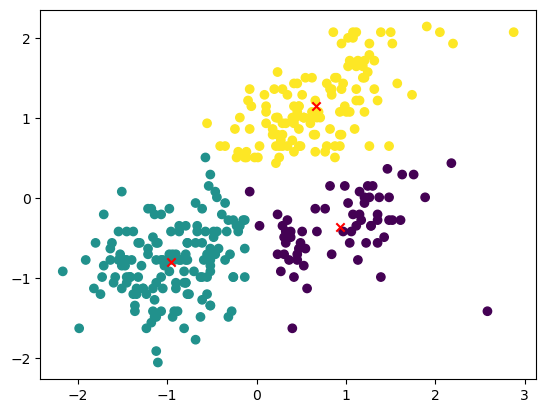

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3).fit(X_scaled)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='red')


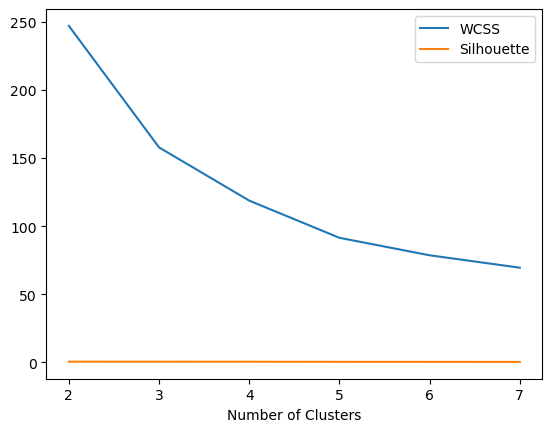

In [5]:
from sklearn.metrics import silhouette_score

wcss = []
silhouette = []

for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    wcss.append(km.inertia_)
    silhouette.append(silhouette_score(X_scaled, km.labels_))

plt.plot(range(2, 8), wcss, label="WCSS")
plt.plot(range(2, 8), silhouette, label="Silhouette")
plt.xlabel("Number of Clusters")
plt.legend()
plt.show()


In [15]:
import pandas as pd

# Load the yogurt dataset
df = pd.read_csv("yogurt_data.csv")

# Melt choice indicators
long_df = df.melt(id_vars=["id"], value_vars=["y1", "y2", "y3", "y4"],
                  var_name="yogurt", value_name="chosen")

# Melt price variables
price_df = df.melt(id_vars=["id"], value_vars=["p1", "p2", "p3", "p4"],
                   var_name="yogurt", value_name="price")

# Melt feature variables
feature_df = df.melt(id_vars=["id"], value_vars=["f1", "f2", "f3", "f4"],
                     var_name="yogurt", value_name="feature")

# Align column names for merging
price_df["yogurt"] = price_df["yogurt"].str.replace("p", "y")
feature_df["yogurt"] = feature_df["yogurt"].str.replace("f", "y")

# Merge all into a long-format DataFrame
long_df = long_df.merge(price_df, on=["id", "yogurt"])
long_df = long_df.merge(feature_df, on=["id", "yogurt"])

# Create a numeric alternative ID
long_df["alt"] = long_df["yogurt"].str.extract(r'(\d)').astype(int)

# Preview the result
print(long_df.head())


   id yogurt  chosen  price  feature  alt
0   1     y1       0  0.108        0    1
1   2     y1       0  0.108        0    1
2   3     y1       0  0.108        0    1
3   4     y1       0  0.108        0    1
4   5     y1       0  0.125        0    1


In [16]:
# Using statsmodels
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit

# Build the design matrix and response
X = long_df[['price', 'feature']]
y = long_df['chosen']
model = MNLogit(y, sm.add_constant(X))
result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.552448
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                 chosen   No. Observations:                 9720
Model:                        MNLogit   Df Residuals:                     9717
Method:                           MLE   Df Model:                            2
Date:                Fri, 13 Jun 2025   Pseudo R-squ.:                 0.01758
Time:                        14:00:02   Log-Likelihood:                -5369.8
converged:                       True   LL-Null:                       -5465.9
Covariance Type:            nonrobust   LLR p-value:                 1.835e-42
  chosen=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1173      0.092    -23.043      0.000      -2.297      -1.937
price         11.8761      1.

In [20]:
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
import numpy as np

# Define BIC calculation function
def bic(log_likelihood, n, k):
    return -2 * log_likelihood + k * np.log(n)

bic_vals = []

for c in [2, 3, 4, 5]:
    gmm = GaussianMixture(n_components=c, random_state=42)
    X_gmm_input = X_latent.reshape(N, -1)
    gmm.fit(X_gmm_input)
    responsibilities = gmm.predict_proba(X_gmm_input)

    total_loglike = 0
    total_params = 0

    for k in range(c):
        weights_long = np.repeat(responsibilities[:, k], 4)
        
        # ✅ Fixed: Removed deprecated 'multi_class' parameter
        model = LogisticRegression(solver='lbfgs', max_iter=200)
        model.fit(X_long, y_long, sample_weight=weights_long)

        probs = model.predict_proba(X_long)
        chosen_probs = probs[np.arange(len(y_long)), y_long]
        loglike_k = np.sum(weights_long * np.log(chosen_probs + 1e-12))
        total_loglike += loglike_k

        total_params += X_long.shape[1] * (model.coef_.shape[0] - 1)

    total_params += c - 1  # Add class weight parameters
    bic_val = bic(total_loglike, N, total_params)
    bic_vals.append((c, bic_val))

# Print results
print("Latent-Class MNL BIC Results:")
for c, b in bic_vals:
    print(f"{c} classes → BIC = {b:.2f}")


Latent-Class MNL BIC Results:
2 classes → BIC = 10758.50
3 classes → BIC = 10735.36
4 classes → BIC = 10742.26
5 classes → BIC = 10730.73
